# Supervised Learning Project

In this project,my goal is to predict whether a customer will leave Beta Bank soon. I have the data on clients’ past 
behavior and termination of contracts with the bank.

I want to:
1. Build a model with the maximum possible F1 score. In this project, my threshold for F1 score will be 0.59 
2. Additionally, i will measure the AUC-ROC metric and compare it with the F1 score.


In [4]:
#Loading all the libraries i will use:
import pandas as pd
import numpy as np
import datetime
import math 
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")
import requests 
import io
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import f1_score

## Data Preparation 

In [5]:
# Downloading the csv file from my GitHub account

url = "https://raw.githubusercontent.com/yoav-karsenty/Supervised-Learning-/main/Churn%20(1).csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

bank = pd.read_csv(io.StringIO(download.decode('utf-8')))


# Exploring the data
bank.head(7)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0


In [6]:
#getting more information about the dataset
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [7]:
bank[bank['Tenure'].isna()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [8]:
bank['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

As we can see, there are 909 rows with missing values in the Tenure column. I can't replace those values so i will later drop them as they are only 9% of the data. 

In [10]:
bank.duplicated().sum()

0

In [11]:
#Lowering all gthe columns names, that will make my work easier.
bank.columns = bank.columns.str.lower()

In [12]:
#droping the 'rownumber' column, i doesnt contain relevent data for thhis project.
bank.drop(['rownumber'],axis =1,inplace = True)

Next, i want to see wich features are categorical and wich are numerical. I will also check the corralation between the columns, To see if there are any column that can be droped due to high correlation. 

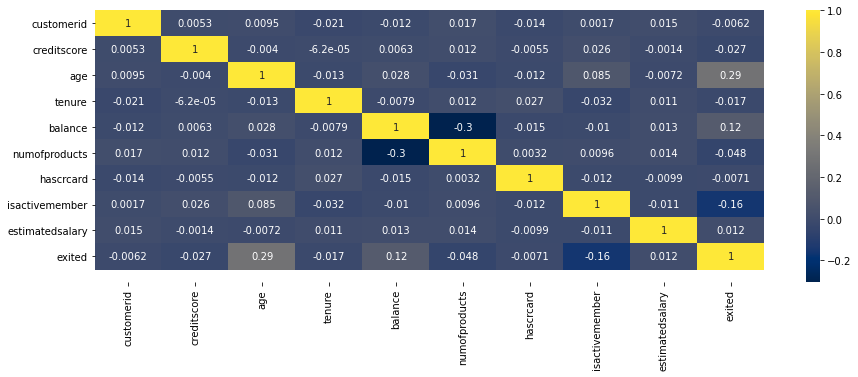

In [13]:
#Checking the corralation between the columns
plt.figure(figsize = (15,5))
ax = sns.heatmap(bank.corr(),annot =True,cmap = 'cividis')
bottom,top = ax.get_ylim()
ax.set_ylim (bottom + 0.5);
plt.yticks(rotation = 0);

We can see from the heatmap above that there are no strong corralations between any columns, so i will keep alll the columns for now.

In [14]:
bank.head()

,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [15]:
bank.geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [16]:
bank.gender.value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

I can see that the 'geography' and 'gender' features are categorical. Next i will plot a histogram that will show me the rest.  

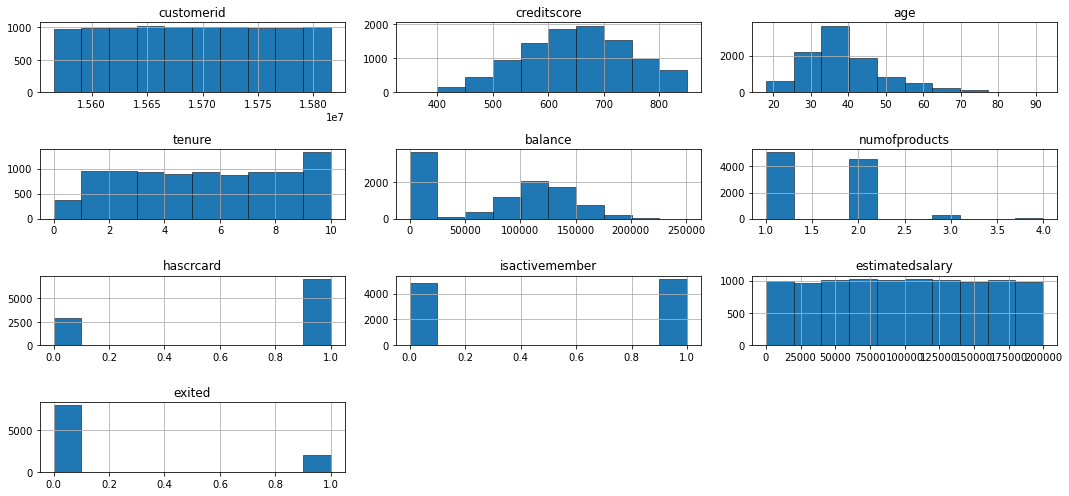

In [17]:
#plotting a histogram that will help me understand wich features are categorical and wich are numerical
bank.hist(edgecolor = 'black',linewidth = 0.5,figsize = (15,7))
plt.tight_layout()
plt.show()

from this visualisation, i can see that the categorical features are 'numofproducts','hascard','isactivemember' and of course the target column 'exited'. 

Next i will One Hot Encode the categoraical features so i could train the model successfully, but first i am going to drop the 'customerid' and 'surname' features, i wont be needing them to train my model.

In [18]:
#Dropping the 'customerid','surname' columns.
bank.drop(['customerid','surname'],axis = 1, inplace = True)

In [19]:
#Changing the type of the 'numofproducts' column so it will get encoded with the rest of the categorical features 
bank.numofproducts = bank.numofproducts.astype('object')

Next, i will call the pd.get_dummies() function to get  separate columns for each feature value.
I will set the drop_first = True, so it will remove any unnecessary colunmns -coulumns that there values can be easily inferred from the other coliumns.

In [20]:
#calling the pd.get_dummies function 
bank_ohe = pd.get_dummies(bank,drop_first=True)


In [21]:
bank_ohe.head()

,creditscore,age,tenure,balance,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male,numofproducts_2,numofproducts_3,numofproducts_4
0,619,42,2.0,0.00,1,1,101348.88,1,0,0,0,0,0,0
1,608,41,1.0,83807.86,0,1,112542.58,0,0,1,0,0,0,0
2,502,42,8.0,159660.80,1,0,113931.57,1,0,0,0,0,1,0
3,699,39,1.0,0.00,0,0,93826.63,0,0,0,0,1,0,0
4,850,43,2.0,125510.82,1,1,79084.10,0,0,1,0,0,0,0


Before training my model, i will examine the balance of classes

In [22]:
bank.exited.value_counts()

0    7963
1    2037
Name: exited, dtype: int64

From this investigation, we can tell that whave imbalenced classes, there  a lot more 0 values in the target column then 1 values. I will start training my model without balancing the dataset, and compare it later with the adjusted version.

## Spliting the source data into a training set, a validation set, and a test set.


Next, i will split the dataset into a training set, a validation set, and a test set. 
The sizes of validation set and test set are usually equal, so i will use  split the data in a 3:1:1 ratio: 20% for the test, 20% for validation and 60% for training


In [23]:
#splitting the data and removing the missing values i found earlier
train_set, plan_test = train_test_split(bank_ohe.dropna(), test_size=0.2,train_size=0.8, random_state=54321,shuffle =True )
plan_train, plan_valid = train_test_split(train_set, random_state=54321,test_size = 0.25,train_size =0.75) 

#Declaring features and target variables 
features_train = plan_train.drop(['exited'], axis=1)
target_train = plan_train['exited']
features_valid = plan_valid.drop(['exited'], axis=1)
target_valid = plan_valid['exited']
features_test = plan_test.drop(['exited'], axis=1)
target_test = plan_test['exited']

## Investigating the quality of different models

Next, I want to Investigate the quality of different models by changing hyperparameters. I will  use  classification models for this project, becasue we are dealing with two potential outcomes :1 = exited, 0 = didnt exit. The models i am going to examine are RandomForestClassifier and LogisticRegression.

In [24]:
#creating a loop that checks the best number for the n_estimators Hyperparameter and max_depth Hyperparameter

best_model = None
best_result = 0.50
best_est = 0
best_depth = 0
for est in range(1, 30,2):
    for depth in range (1, 30):
        model = RandomForestClassifier(random_state=54321, n_estimators=est,max_depth = depth ) 
        model.fit(features_train,target_train) # train model on training set
        predicted_valid = model.predict(features_valid)

        f1 = f1_score(target_valid,predicted_valid)
        if f1 > best_result: 
            
            best_result = f1
            best_est = est
            best_depth = depth
print("The best f1 score:",best_result,"Best est : ",best_est,"best_depth : ",best_depth)
 

The best f1 score: 0.6006493506493508 Best est :  17 best_depth :  24


We got a 0.60 score using the RandomForestClassifier with max_depth = 24 and n_estimators = 17. This score is better than the threshold that was set, 059, but i still want to check if the model can't improve.  
I will try to train a LogisticRegression and see if the model imroves

In [25]:
#creating a loop that checks the best number for the max_iter Hyperparameter and the best solver Hyperparameter

best_model = None
l_best_result = 0.50
best_solver = 'lbfgs'
best_iter = 0
for iter_it in range (1, 100,10):
    for s in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
        

        lr_model = LogisticRegression(random_state=12345, solver=s,max_iter = iter_it) 
        lr_model.fit(features_train, target_train) 
        l_predicted_valid = model.predict(features_valid)
        l_f1 = f1_score(target_valid,predicted_valid)
        if l_f1 > l_best_result:
            best_model = lr_model
            l_best_result = l_f1 
            best_solver = s
            best_iter = iter_it

print("The best  f1 score:",l_best_result,"Best solver : ",best_solver," best itter : ",best_iter)


The best  f1 score: 0.5862646566164154 Best solver :  newton-cg  best itter :  1


As we can see, using LogisticRegression didnt improve the model's f1 score (now its 0.58).


Next, i will balance the classes and try Improve the quality of the model.
I will use  three approaches to fixing class imbalance:
1. Adjusting The class_weight parameter
2. Upsampling 
3. Downsampling 

### Adjusting The class_weight parameter


In [26]:
#creating a loop that checks the best number for the n_estimators Hyperparameter and max_depth Hyperparameter 
##With class_weight='balanced'

best_model = None
best_result = 0.50
best_est = 0
best_depth = 0
for est in range(1, 30,2):
    for depth in range (1, 30):
        model = RandomForestClassifier(random_state=54321, n_estimators=est,max_depth = depth,class_weight='balanced') 
        model.fit(features_train,target_train) # train model on training set
        predicted_valid = model.predict(features_valid)

        f1 = f1_score(target_valid,predicted_valid)
        if f1 > best_result: 
            
            best_result = f1
            best_est = est
            best_depth = depth
print("The best f1 score:",best_result,"Best est : ",best_est,"best_depth : ",best_depth)
 

The best f1 score: 0.6452353616532721 Best est :  19 best_depth :  7


We can see the f1 score has improved to 0.64 with the  RandomForestClassifiermodel

In [27]:
#creating a loop that checks the best number for the max_iter Hyperparameter and the best solver Hyperparameter
##With class_weight='balanced'

best_model = None
l_best_result = 0.50
best_solver = 'lbfgs'
best_iter = 0
for iter_it in range (1, 250,10):
    for s in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
        

        lr_model = LogisticRegression(random_state=12345, solver=s,max_iter = iter_it,class_weight='balanced') 
        lr_model.fit(features_train, target_train) 
        l_predicted_valid = model.predict(features_valid)
        l_f1 = f1_score(target_valid,predicted_valid)
        if l_f1 > l_best_result:
            best_model = lr_model
            l_best_result = l_f1
            best_solver = s
            best_iter = iter_it

print("The best  f1 score:",l_best_result,"Best solver : ",best_solver," best itter : ",best_iter)


The best  f1 score: 0.561525129982669 Best solver :  newton-cg  best itter :  1


We can see the f1 score has not improved with 0.56 using the  LogisticRegression model.

### Upsampling 


In [28]:
#creating a function that will return  the features and target after upsampling
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train, target_train, 20
)

model = LogisticRegression(random_state = 12345,solver = 'newton-cg',)



model.fit(features_upsampled,target_upsampled)
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.40022172949002216


### Downsampling

In [29]:
#creating a function that will return  the features and target after upsampling

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.1
)

model = LogisticRegression(random_state = 12345,solver = 'newton-cg')
model.fit(features_downsampled,target_downsampled)
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.45551128818061093


In [30]:
model = RandomForestClassifier(random_state=54321, n_estimators=19,max_depth = 7,class_weight='balanced') 
model.fit(features_downsampled,target_downsampled)
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.5373134328358209


In [31]:
model = RandomForestClassifier(random_state=54321, n_estimators=19,max_depth = 7,class_weight='balanced') 
model.fit(features_upsampled,target_upsampled)
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))


F1: 0.6086956521739131


It looks like upsampling and downsampling didnt improve the model. I got the best F1 score with the model : 

RandomForestClassifier(random_state=54321, n_estimators=19,max_depth = 7,class_weight='balanced')

I will train my model with those parameters. 

In [32]:
#Testing the final model with the test dataset
final_model = RandomForestClassifier(random_state=54321, n_estimators=19,max_depth = 7,class_weight='balanced') 
final_model.fit(features_train,target_train) # train model on training set
predicted_test = final_model.predict(features_test)

f1f = f1_score(target_test,predicted_test)
f1f

0.6002190580503833

We got a 0.60 score, wich makes our model a successful model based on the 0.59 threshold.

Finnaly, i want to check the quality of the model by 
calculating AUC-ROC. The closer the AUC-ROC is to 1, the he better the model's quality. The AUC-ROC value for a random model is 0.5.

In [34]:

final_model = RandomForestClassifier(random_state=54321, n_estimators=19,max_depth = 7,class_weight='balanced') 
final_model.fit(features_train,target_train) # train model on training set
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_test,probabilities_one_valid)
print(auc_roc)

0.846155093042858
